In [1]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import copy
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap.umap_ as umap
import torchvision.transforms as T
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [49]:
#Variables
path = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face'
BATCH_SIZE = 10
EPOCHS = 1000
applier = T.RandomApply(transforms=[T.RandomVerticalFlip(p=0.5),
                                    T.RandomHorizontalFlip(p=0.5)
                                    ,T.RandomRotation(20),
                                    T.RandomRotation(75)]
                        ,p=0.5)
width_img = 60
height_img = 60
INPUT_SIZE = width_img*height_img
HIDDEN_SIZE = 100
OUTPUT_SIZE = 1
learning_rate = 0.01
loss_fn = nn.BCEWithLogitsLoss()
#resize = None
resize = transforms.Resize(size = (width_img,height_img))

In [50]:
def read_image(path) :
    """Read content of data folders, and store inside a dictionary object:
    - 'img_dir' key contains paths of images
    - 'label' key contains the level of difficulty to determine if the image is fake or not
    - 'label_bin' key contains the true value of reality (fake/real) of every picture.  
    Input: path
    Output: Dict(img_dir, label, label_bin)
    """
    img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
    for root, dirs, files in os.walk(path):
        for img in files:
            img_dict["img_dir"].append(os.path.join(root, img))
                
            img_dict["label"].append(img[:4])
            if img[:4] != 'real':
                img_dict["label_bin"].append(0.0)
            else:
                img_dict["label_bin"].append(1.0)
    return img_dict

# Data set class
class FaceDataset(Dataset):

    def __init__(self, image_dir, label_bin,
                 label=None, transform = None, train = False):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.label_bin = label_bin
        self.label = label
        self.img_dir = [(image, 'original') for image in image_dir]
        if train:
            self.img_dir.extend([(image, 'aug') for image in image_dir])
            
            self.label_bin.extend(label_bin)
            if label:
                self.label.extend(label)
        self.transform = transform

        
    def __len__(self) :
        return len(self.label_bin)


    def __getitem__(self, index) :
        path = torch.from_numpy(io.imread(self.img_dir[index][0],
                                         as_gray=True).astype(np.float32)).unsqueeze(0)
        label = torch.tensor(self.label_bin[index],dtype=torch.float32)

        if self.transform and self.img_dir[index][1] == 'aug':
            path = self.transform(path)
        if self.label:
            label = self.label[index]
        #path = transforms.Resize(size = (30,30))(path)

        return path, label

In [51]:
def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()
        
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm,)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()

In [52]:
class EarlyStopping:
    """Define an Early Stopping for our models"""
    def __init__(self, patience=15):
        
        self.patience = patience #number of epochs without loss decrease to tolerate before stopping
        self.counter = 0 # epochs without loss decrease
        self.min_validation_loss = np.inf #initialise min_loss to infinite


    def stop_train(self, validation_loss):
        """update min_validation_loss if current valid_loss < min_validation_loss,
        reset counter to 0 and save model parameters
        else increment counter value by 1, stop training if counter >= patience
        Args:
            validation_loss: current validation loss
        Returns:
            bool: Stops the train or not
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [53]:
#Load data
all_data = read_image(path)
label, label_bin, img_dir = all_data["label"],  all_data["label_bin"],all_data["img_dir"]
# Divide 80% for train
label_tr, label_test, label_bin_tr, label_bin_test, img_dir_tr, img_dir_test = train_test_split(label,
                                                                                                label_bin,
                                                                                                img_dir, 
                                                                                                test_size=0.2)

# Use 10% for validation and 10% for test
label_val, label_test, label_bin_val, label_bin_test, img_dir_val, img_dir_test= train_test_split(label_test,
                                                                  label_bin_test,
                                                                  img_dir_test, 
                                                                  test_size=0.5)

# Load with Dataset class
train_dataset = FaceDataset(img_dir_tr,label_bin_tr,
                            transform=applier, train=True)
valid_dataset = FaceDataset(img_dir_val,label_bin_val)
test_dataset = FaceDataset(img_dir_test,label_bin_test)

#Build Dataloader
train_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True )
valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                               drop_last=True)

len(train_dataset)

3264

In [30]:
def accuracy_fn(y_true, y_pred):
    """Return accuracy"""
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


def eval_binary_classifier(model, eval_dataloader, loss_fn, resize = None,mlp = False):
    sigmoid = nn.Sigmoid()
    model.eval() 
    #model.to(device)
    if resize:
        transform = resize
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss, accuracy = 0, 0
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:
            #images = torch.tensor(images, dtype=float)
            if resize:
                images = transform(images)
            #labels.to(device)
            if mlp:
                
                images = images.reshape(images.shape[0], -1)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images.to(device))

            if mlp:
                l = loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            else:
                l = loss_fn(y_predicted, labels.view(-1, 1).to(device))
            loss += l.item()
            accuracy += accuracy_fn(labels.to(device), torch.round(sigmoid(y_predicted)).squeeze(1))
        accuracy = accuracy/len(eval_dataloader)

    return loss, accuracy

def train_val_binary_classifier(model, train_dataloader, 
                                valid_dataloader, num_epochs, 
                                loss_fn, learning_rate, resize=None,verbose=True,
                                file_name='model_parameters.pt',
                                mlp = False):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate,
                               momentum=0.9)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss, valid_acc = [], []
    if resize:
        transform = resize
    
    #Initialize earlystopping
    early_stopping = EarlyStopping()
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            if resize:
                images = transform(images)
            if mlp:
                images = images.reshape(images.shape[0], -1)

            y_pred = model_tr(images.to(device))
            if mlp:
                l = loss_fn(y_pred, labels.unsqueeze(1).to(device))
            else:
                l = loss_fn(y_pred, labels.view(-1, 1).to(device))
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()


        scheduler.step()
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn, resize=resize, mlp=mlp)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)

        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Valid loss: {val_loss:.5f} | Valid acc: {accuracy:.2f}%\n")
            
        if epoch >0 and val_loss < min(valid_loss[:-1]):
            #save parameters if val_loss decreases 
            
            torch.save(model_tr.state_dict(), file_name)
            print('Saved new state.')
            
        if early_stopping.stop_train(val_loss): 
            #stop training if early stopping triggered 
            print('Early stopping activated, stop training at epoch #{}.'.format(epoch+1))
            break
            

            
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

In [31]:
class MLPClassif(nn.Module):
    """Our FeedForward Network"""
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassif, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.hidden4 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        
    
    def forward(self, x):

        #sigmoid = nn.Sigmoid()
        x = self.layer1(x)
        x = self.relu(x)
        #x = self.dropout1(x)
        x = self.batchnorm(x)
        x = self.layer2(x)
        x = self.relu(x)
        #x = self.dropout2(x)
        x = self.batchnorm(x)
        x = self.hidden3(x)
        x = self.relu(x)
        #x = dropout(x)
        x = self.hidden4(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        #x = dropout(x)
        out = self.out_layer(x)
        return out

In [32]:
# Initialize MLP and train it

model = MLPClassif(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
model.apply(init_weights)

model = model.to(device)
print('Train on GPU: '+ str(next(model.parameters()).is_cuda))
model_mlp, mlp_history = train_val_binary_classifier(model, 
                                                     train_data_loader,
                                                     valid_data_loader,
                                                     EPOCHS,loss_fn,
                                                     learning_rate, 
                                                     verbose=True,
                                                     resize=resize,
                                                     file_name='mlp_parameters.pt',
                                                     mlp = True)

Train on GPU: True

Epoch [1/1000]
Train loss: 124.50746 | Valid loss: 24.05790 | Valid acc: 54.50%


Epoch [2/1000]
Train loss: 126.39532 | Valid loss: 13.76897 | Valid acc: 57.50%

Saved new state.

Epoch [3/1000]
Train loss: 117.76882 | Valid loss: 14.05019 | Valid acc: 51.00%


Epoch [4/1000]
Train loss: 114.36652 | Valid loss: 13.86632 | Valid acc: 55.00%


Epoch [5/1000]
Train loss: 112.73290 | Valid loss: 14.21767 | Valid acc: 54.00%


Epoch [6/1000]
Train loss: 113.42711 | Valid loss: 14.12728 | Valid acc: 52.50%


Epoch [7/1000]
Train loss: 112.12312 | Valid loss: 14.15917 | Valid acc: 56.50%


Epoch [8/1000]
Train loss: 111.31116 | Valid loss: 13.85558 | Valid acc: 57.00%


Epoch [9/1000]
Train loss: 111.94809 | Valid loss: 13.72283 | Valid acc: 55.00%

Saved new state.

Epoch [10/1000]
Train loss: 108.41309 | Valid loss: 14.52320 | Valid acc: 56.50%


Epoch [11/1000]
Train loss: 108.40760 | Valid loss: 14.42838 | Valid acc: 53.00%


Epoch [12/1000]
Train loss: 107.69889 | Va

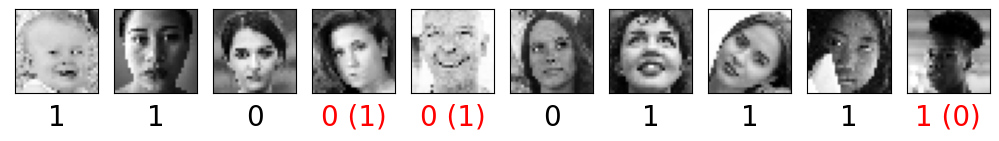

In [33]:
#Small overview of results

def test_overview(model, dataloader, resize = None):
    """Display an overview of the results over the first batch of the dataloader 

    Args:
        model : Trained model
        dataloader: Dataloader
        resize (_type_, optional): Transformation to apply to all images of the batch.
        Defaults to None.
    """
    sigmoid = nn.Sigmoid()
    x_test, y_test = next(iter(dataloader))
    if resize:
        transform = resize
        x_test = transform(x_test)
    y_pred = model(x_test.squeeze().view(x_test.shape[0],-1).to(device)).cpu()
    y_test = y_test.numpy().astype(int)
    y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
    x_test = x_test.squeeze().numpy()
    plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)
test_overview(model_mlp, test_data_loader, resize=resize)

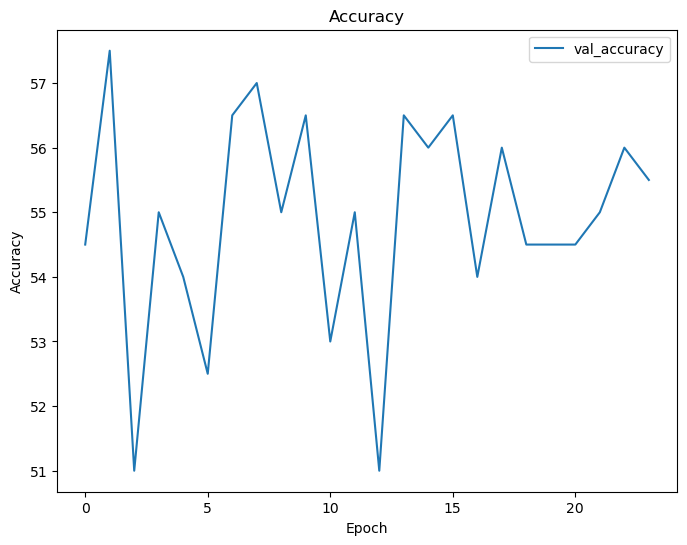

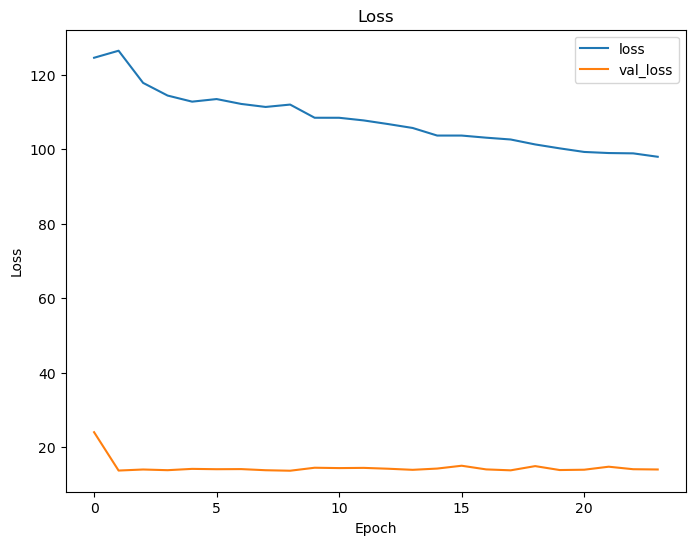

In [34]:
#Plot validation accuracy and loss curves
plot_history(mlp_history)

In [35]:
# Evaluation of the MLP on the test dataloader
print("Accuracy: "+ str(eval_binary_classifier(model_mlp, test_data_loader, loss_fn=loss_fn, 
                       resize = resize, mlp=True)[1]))

(13.567108571529388, 61.0)

# CNN

In [60]:
class CNN(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32,num_channels3 = 64, num_classes=1):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= num_channels1, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))

        
        self.layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels2,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels3,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(3136, num_classes)

    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        x=self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x=self.layer3(x)
        #out = self.fc(x.view(-1, 32*7*7))
        x= x.reshape(x.size(0), -1)
        #print(x.shape)
        out = self.fc(x)
        return out

In [ ]:
learning_rate = 0.01
# Initialize CNN and train it
model_cnn = CNN()
model_cnn.apply(init_weights)
model_cnn.to(device)
print('Train on GPU: '+ str(next(model_cnn.parameters()).is_cuda))

model_cnn, cnn_history= train_val_binary_classifier(model_cnn, 
                                                train_data_loader,valid_data_loader, 
                                                EPOCHS,loss_fn, learning_rate, verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=resize)

Train on GPU: True

Epoch [1/1000]
Train loss: 2442.29201 | Valid loss: 99.71340 | Valid acc: 54.50%


Epoch [2/1000]
Train loss: 673.43759 | Valid loss: 16.07669 | Valid acc: 63.50%

Saved new state.

Epoch [3/1000]
Train loss: 477.31217 | Valid loss: 19.57642 | Valid acc: 49.50%


Epoch [4/1000]
Train loss: 352.88206 | Valid loss: 13.66788 | Valid acc: 62.00%

Saved new state.

Epoch [5/1000]
Train loss: 311.56857 | Valid loss: 16.38989 | Valid acc: 56.50%


Epoch [6/1000]
Train loss: 294.41113 | Valid loss: 29.38335 | Valid acc: 45.00%


Epoch [7/1000]
Train loss: 322.89276 | Valid loss: 13.62097 | Valid acc: 61.00%

Saved new state.

Epoch [8/1000]
Train loss: 325.09599 | Valid loss: 14.05781 | Valid acc: 59.00%


Epoch [9/1000]
Train loss: 276.81234 | Valid loss: 18.96380 | Valid acc: 58.50%


Epoch [10/1000]
Train loss: 290.51419 | Valid loss: 15.86308 | Valid acc: 58.50%


Epoch [11/1000]
Train loss: 256.27369 | Valid loss: 21.40293 | Valid acc: 55.50%


Epoch [12/1000]
Train lo

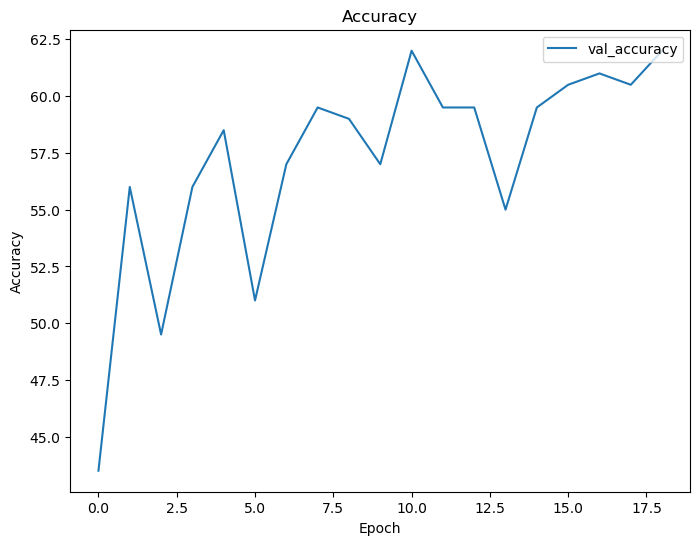

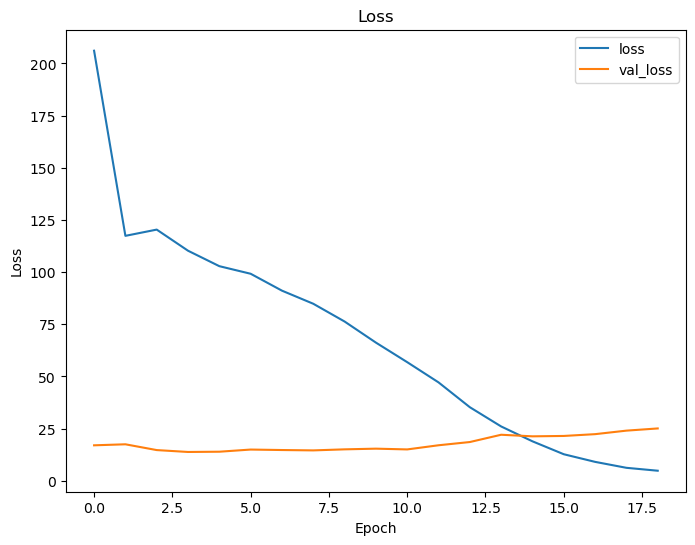

In [41]:
# Plot validation accuracy and loss curves
plot_history(cnn_history)

In [ ]:
# Evaluation of the CNN on the test dataloader
print("Accuracy: "+ str(eval_binary_classifier(model_cnn, test_data_loader, loss_fn=loss_fn, resize=resize))[1])

In [ ]:
def extract_TSNE_embeddings(model, data_loader, train_dataset, batch_size, len_layer,
                        transform=None, mlp = False):
    
    """Compute T-SNE Embeddings"""
    feature_maps_tot = torch.empty((len(train_dataset), len_layer), dtype=torch.float).to(device)
    labels_fm_tot = torch.empty(len(train_dataset), dtype=torch.float)

    model.eval()
    with torch.no_grad():
        for ib, (images, labels) in enumerate(data_loader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            labels_fm_tot[indices_b] = labels.float()
            if transform:
                images = transform(images)
            if mlp:
                images = images.reshape(images.shape[0], -1)
            out = model.layer1(images.to(device))
            out = model.layer2(out)
            feats_vec = out.reshape(batch_size, -1)
            feature_maps_tot[indices_b, :] = feats_vec

    feature_maps_tot = feature_maps_tot.cpu().numpy()
    labels_fm_tot = labels_fm_tot.numpy()
    print('Size of vectorized feature maps:', feature_maps_tot.shape)
    print('Size of the tensor storing labels:', labels_fm_tot.shape)
    feature_maps_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
    print('Size TSNE embeddings (feature maps):', feature_maps_TSNE.shape)
    return feature_maps_TSNE, labels_fm_tot


tsne_embeddings_mlp = extract_TSNE_embeddings(model_mlp, train_data_loader,
                                       train_dataset, BATCH_SIZE, len_layer = HIDDEN_SIZE, transform = resize,
                                       mlp = True
                                       )
plot_embeddings(tsne_embeddings_mlp[0], tsne_embeddings_mlp[1], "MLP")

In [ ]:
tsne_embeddings_cnn = extract_TSNE_embeddings(model_cnn, train_data_loader,
                                       train_dataset, BATCH_SIZE, len_layer = 7200, transform = resize,
                                       
                                       )
plot_embeddings(tsne_embeddings_cnn[0], tsne_embeddings_cnn[1], 'CNN')